#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [3]:
d, Nobs = 10, 100
p = 1e-1
X = sprandn(d, Nobs, 1e-1)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

prior = SS_prior(d, σ02)
# prior = GDP_prior(d, σ02)
# prior = SS_prior(d, σ02)
# prior = gaussian_prior_nh(zeros(d), 10*rand(d))

SS_prior(10, 1.0, [1, 1, 1, 1, 1, 1, 1, 1, 1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.01, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [5]:
# Sub-sampling with weights and no CV

mb_size = 300
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)

@showprogress for i in 2:d
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [6]:
A_xi = eye(d)
A_hyp = eye(hyperparam_size(prior))
# A_xi = ones(1,d)/d
# A_hyp = ones(1, hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(10^6, 2*10^5)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [7]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [8]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e2)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [9]:
start = time()
ZZ_block_sample(my_model, outp, blocksampler, mstate)
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.55 mins 
20% attempts in 1.09 mins 
Trimmed after 200000 bouncing attempts 
30% attempts in 1.67 mins 
40% attempts in 2.25 mins 
50% attempts in 2.84 mins 
60% attempts in 3.45 mins 
70% attempts in 4.06 mins 
80% attempts in 4.67 mins 
90% attempts in 5.34 mins 
100% attempts in 6.02 mins 
6.02 mins

In [10]:
print(maximum(abs.(outp.opf.xi_mu - mstate.mu)), "\n")
print(maximum(abs.(outp.opf.xi_m2 - mstate.m2)))

0.006478148796318667
0.0646312464483687

In [74]:
outp.opf.xi_mu

10-element Array{Float64,1}:
   72.7619
 -260.672 
  297.61  
 -259.204 
  255.719 
  163.877 
 -221.2   
 -346.106 
 -230.602 
  219.76  

In [75]:
mstate.mu

10-element Array{Float64,1}:
 -0.782962
  0.872431
  0.124166
  0.730064
 -0.96346 
  0.226062
 -0.607016
  0.893431
 -0.237345
 -0.241049

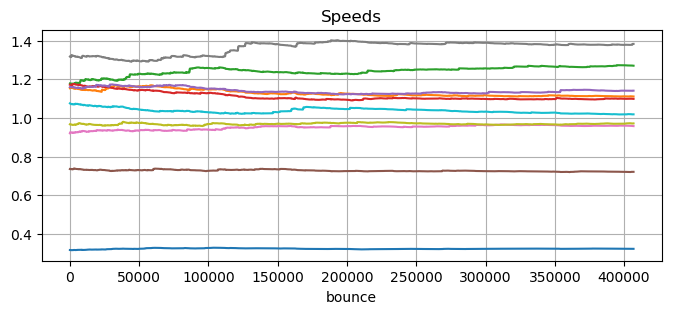

In [20]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [21]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

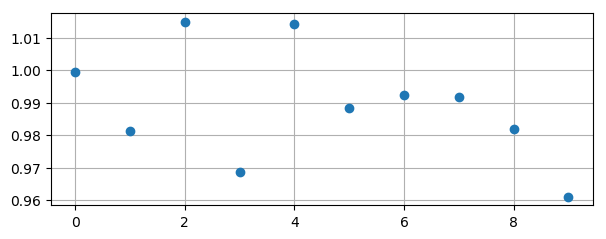

In [22]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)

In [26]:
mean(xi_samples,2)

10×1 Array{Float64,2}:
 -0.780635
  0.864065
  0.103834
  0.701895
 -0.997316
  0.235366
 -0.62983 
  0.945112
 -0.283572
 -0.247065

In [28]:
mstate.mu

10-element Array{Float64,1}:
 -0.78084 
  0.872333
  0.106043
  0.722635
 -0.994089
  0.228602
 -0.623865
  0.926438
 -0.277568
 -0.252956

In [14]:
h = 1
B = Int(round(outp.opf.bt_skeleton[1,end]/h))

0

In [42]:
Int.(round.(compute_ESS(outp.opf, B)))

10-element Array{Int64,1}:
  2937
 12632
 11256
  7435
   809
   602
  8017
 25597
  6436
 11668

* OLD:

In [14]:
compute_ESS(outp.opf, 100) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


10-element Array{Float64,1}:
  264.609
 1164.83 
 1853.68 
  554.339
  121.721
  175.505
  524.152
 3153.79 
  473.668
  833.837